# Training the classifier

Import Packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
import os
import random
import copy
%matplotlib inline

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Feature extraction

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
#         image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


Sliding Window Search

In [3]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


Adding Heat and removing Flase positives

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(labels):
    # Iterate through all detected cars
    bbox = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox.append(((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))))
        # Draw the box on the image
#         cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return bbox

Importing images from the folder

In [5]:
## Importing folder names of images

vehicle_direct     = [x[0] for x in os.walk("vehicles/")][1:]
non_vehicle_direct = [x[0] for x in os.walk("non-vehicles/")][1:]

In [6]:
## Importing the vehicle images and creating a pickle file

new_images = []
print('Loading Images...')

for image in vehicle_direct:
    directory = image+'/'
    files     = os.listdir(directory)
    
    for name in files:
        if name[0] != '.':
            image      = (mpimg.imread(directory+name)*255).astype('uint8')
            new_images.append(image)

        
print('Total images for car', len(new_images))
print()

pickle_file = 'car_train_images.p'    


print('Saving Car images to pickle file...')
print()
with open(pickle_file, 'wb') as pfile:
    pickle.dump(
        {
            'images': new_images
        },pfile, protocol = 2)

print()
print('Pickle file  for cars created') 
del new_images

In [7]:
## Importing non vehicle images and creating corresponding pickle file

new_images = []
print('Loading Images...')

for image in non_vehicle_direct:
    directory = image+'/'
    files     = os.listdir(directory)
    
    for name in files:
        if name[0] != '.':
            image      = (mpimg.imread(directory+name)*255).astype('uint8')
            new_images.append(image)

        
print('Total images for non car', len(new_images))
print()

pickle_file = 'non_car_train_images.p'    

if not os.path.isfile(pickle_file):
    print('Saving Car images to pickle file...')
    print()
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'images': new_images
                },pfile, protocol = 2)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
print()
print('Pickle file  for cars created') 

In [10]:
# Read and load cars and notcars images from pickle file. 
# NOTE: The pickle file for the images was created only once and it was used to load the images 
#       whenever it was required instead of loading it from the folder to reduce computation time.

print('Loading Images..')

with open('car_train_images.p', mode='rb') as f:
    cr_img = pickle.load(f)
    
with open('non_car_train_images.p', mode='rb') as f:
    n_cr_img = pickle.load(f)
    
all_cars    = cr_img['images']
all_notcars = n_cr_img['images']

print('Images Loaded')
print('Total car images: ', len(all_cars))
print('Total not car images: ', len(all_notcars))
print()

Loading Images..
Images Loaded
Total car images:  8792
Total not car images:  8968



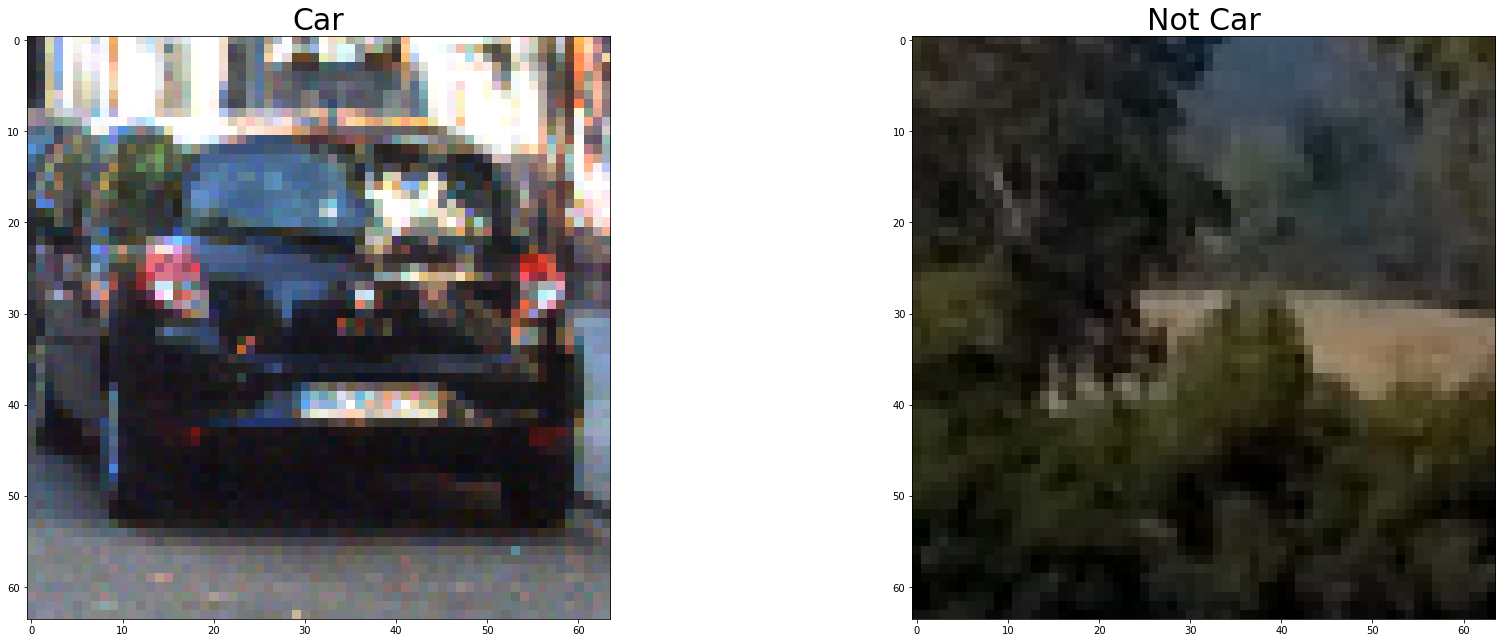

In [9]:
## Plot test images

plot_index = random.randint(0, min(len(all_cars), len(all_notcars)) - 1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(all_cars[plot_index])
ax1.set_title('Car', fontsize=30)
ax2.imshow(all_notcars[plot_index])
ax2.set_title('Not Car', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [28]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [29]:
## Check feature vector lenth for different combinations.

feat_test = extract_features(all_cars[0:1], color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
print(len(feat_test[0]))

5568


Generating feature vectors for both vehicle and non vehicle images. 
After that they are divided into training and test sets and normalized.

In [30]:
batch_size      = 500
batch_no        = 1

train_cars = copy.deepcopy(all_cars)
train_notcars = copy.deepcopy(all_notcars)

train_car_features    = []
test_car_features     = []
train_notcar_features = []
test_notcar_features  = []

print('Extracting features...')
print()
for lower_index in range(0, len(train_cars), batch_size):
    print('Train Car Batch no: ', batch_no)
    upper_index  = min(lower_index + batch_size, len(train_cars ))
    cars         = train_cars[lower_index:upper_index]
    tmp_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    for feat in tmp_features:
        train_car_features.append(feat)
        
    del tmp_features
    batch_no += 1
    
print(len(train_car_features),' features for train cars loaded.')
print()
batch_no = 1
    
for lower_index in range(0, len(train_notcars), batch_size):
    print('NotCar Batch no: ', batch_no)
    
    upper_index  = min(lower_index + batch_size, len(train_notcars ))
    notcars      = train_notcars[lower_index:upper_index]
    tmp_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    for feat in tmp_features:
        train_notcar_features.append(feat)
        
    del tmp_features
    batch_no += 1

print(len(train_notcar_features),' features for non cars loaded.')
print()

test_cars_features = []
test_train_ratio   = 0.175

for i in range(int(test_train_ratio*len(train_car_features))):
    ind = random.randint(len(train_car_features) - 5500, len(train_car_features) - 1)
    test_car_features.append(train_car_features[ind])
    del train_car_features[ind - 1]

rand_state = np.random.randint(0, 100)
train_notcar_features, test_notcar_features = train_test_split(train_notcar_features, 
                                                                 test_size=test_train_ratio, random_state=rand_state)

print('Test cars     :',len(test_car_features))
print('Test not cars :',len(test_notcar_features))
print('Train cars    :',len(train_car_features))
print('Train not cars:',len(train_notcar_features))
print()

print('Normalizing...')
X_train = np.vstack((train_car_features, train_notcar_features)).astype(np.float64)
X_test  = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_train_scaler = StandardScaler().fit(X_train)
X_test_scaler = StandardScaler().fit(X_test)

# Apply the scaler to X
scaled_X_train = X_train_scaler.transform(X_train)
scaled_X_test  = X_test_scaler.transform(X_test)

# Define the labels vector
y_train = np.hstack((np.ones(len(train_car_features)), np.zeros(len(train_notcar_features))))
y_test  = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))

print('Done!!')

Extracting features...

Train Car Batch no:  1
Train Car Batch no:  2
Train Car Batch no:  3
Train Car Batch no:  4
Train Car Batch no:  5
Train Car Batch no:  6
Train Car Batch no:  7
Train Car Batch no:  8
Train Car Batch no:  9
Train Car Batch no:  10
Train Car Batch no:  11
Train Car Batch no:  12
Train Car Batch no:  13
Train Car Batch no:  14
Train Car Batch no:  15
Train Car Batch no:  16
Train Car Batch no:  17
Train Car Batch no:  18
8792  features for train cars loaded.

NotCar Batch no:  1
NotCar Batch no:  2
NotCar Batch no:  3
NotCar Batch no:  4
NotCar Batch no:  5
NotCar Batch no:  6
NotCar Batch no:  7
NotCar Batch no:  8
NotCar Batch no:  9
NotCar Batch no:  10
NotCar Batch no:  11
NotCar Batch no:  12
NotCar Batch no:  13
NotCar Batch no:  14
NotCar Batch no:  15
NotCar Batch no:  16
NotCar Batch no:  17
NotCar Batch no:  18
8968  features for non cars loaded.

Test cars     : 1538
Test not cars : 1570
Train cars    : 7254
Train not cars: 7398

Normalizing...
Done!!


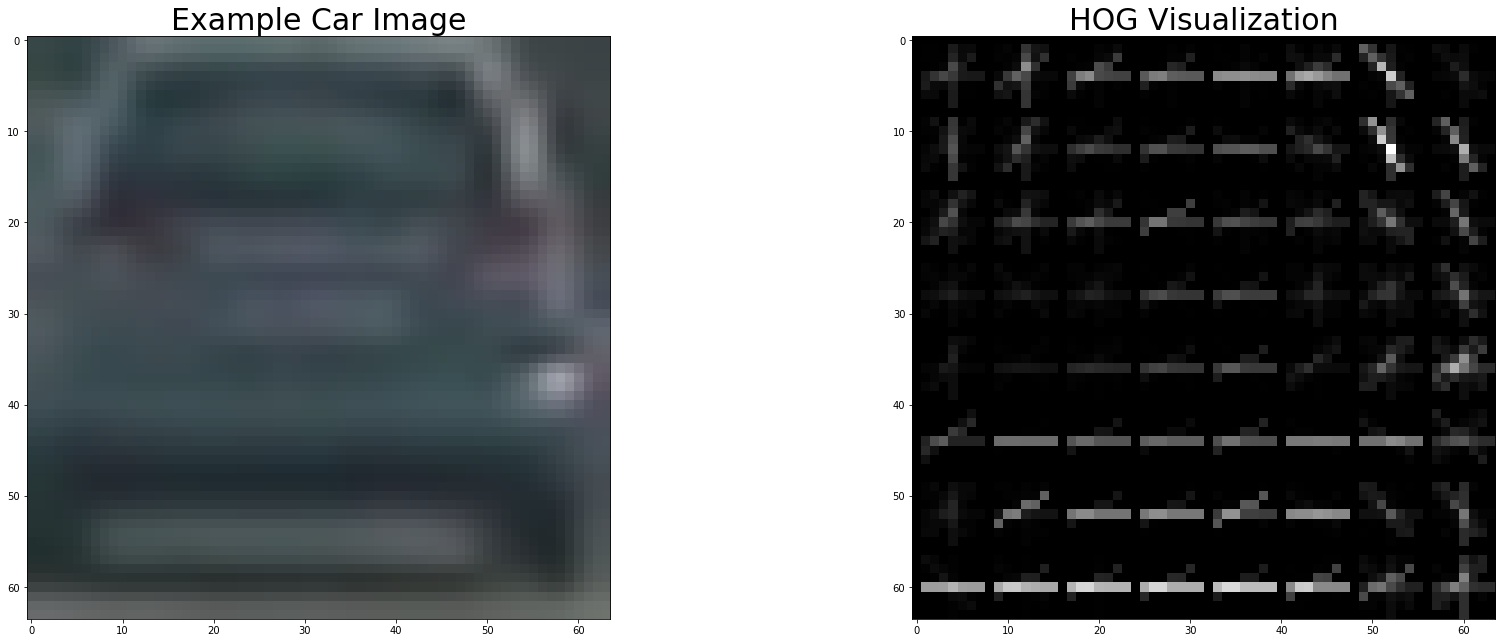

In [31]:
## Plotting the HOG visualization.

tmp_imgs = train_cars[10]
gray = cv2.cvtColor(tmp_imgs, cv2.COLOR_BGR2GRAY)
features11, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


plot_index = random.randint(0, min(len(all_cars), len(all_notcars)) - 1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(tmp_imgs, cmap='gray')
ax1.set_title('Example Car Image', fontsize=30)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Visualization', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [32]:
train_file = 'train_12.p'  
test_file  = 'test_12.p'

print('Saving Features to pickle file...')
print()

with open(train_file, 'wb') as pfile:
    pickle.dump(
        {
            'scalar': X_train_scaler,
            'features': scaled_X_train,
            'labels': y_train
        },pfile)


with open(test_file, 'wb') as pfile:
    pickle.dump(
        {
            'scalar': X_test_scaler,
            'features': scaled_X_test,
            'labels': y_test
        },pfile)    
print('Saved')

del X_train_scaler, scaled_X_train, y_train
del X_test_scaler, scaled_X_test, y_test

Saving Features to pickle file...

Saved


Training and testing the data using Linear SVM model

In [33]:
# Split up data into randomized training and test sets

print('Loading Data..')
print()
with open(train_file, mode='rb') as f:
    feat = pickle.load(f)

X_scaler = feat['scalar']
X_train  = feat['features']
y_train  = feat['labels']
X_train, y_train = shuffle(X_train, y_train)

print(len(X_train), ' train features loaded')

with open(test_file, mode='rb') as f:
    feat = pickle.load(f)

# X_scaler = feat['scalar']
X_test  = feat['features']
y_test  = feat['labels']

print(len(X_test), ' test features loaded')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print()
# Use a linear SVC 

print('Training...')
svc = LinearSVC()
# svc = SVC()
# svc = RandomForestClassifier(n_estimators=10)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Loading Data..

14652  train features loaded
3108  test features loaded
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568

Training...
12.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9965


In [34]:
joblib.dump(svc, 'model_12_svc.pkl')

['model_12_svc.pkl']

In [35]:
train_file = 'train_12.p'
with open(train_file, mode='rb') as f:
    feat = pickle.load(f)

X_scaler = feat['scalar']
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

Finding window locations..

Drawing windows on the image..



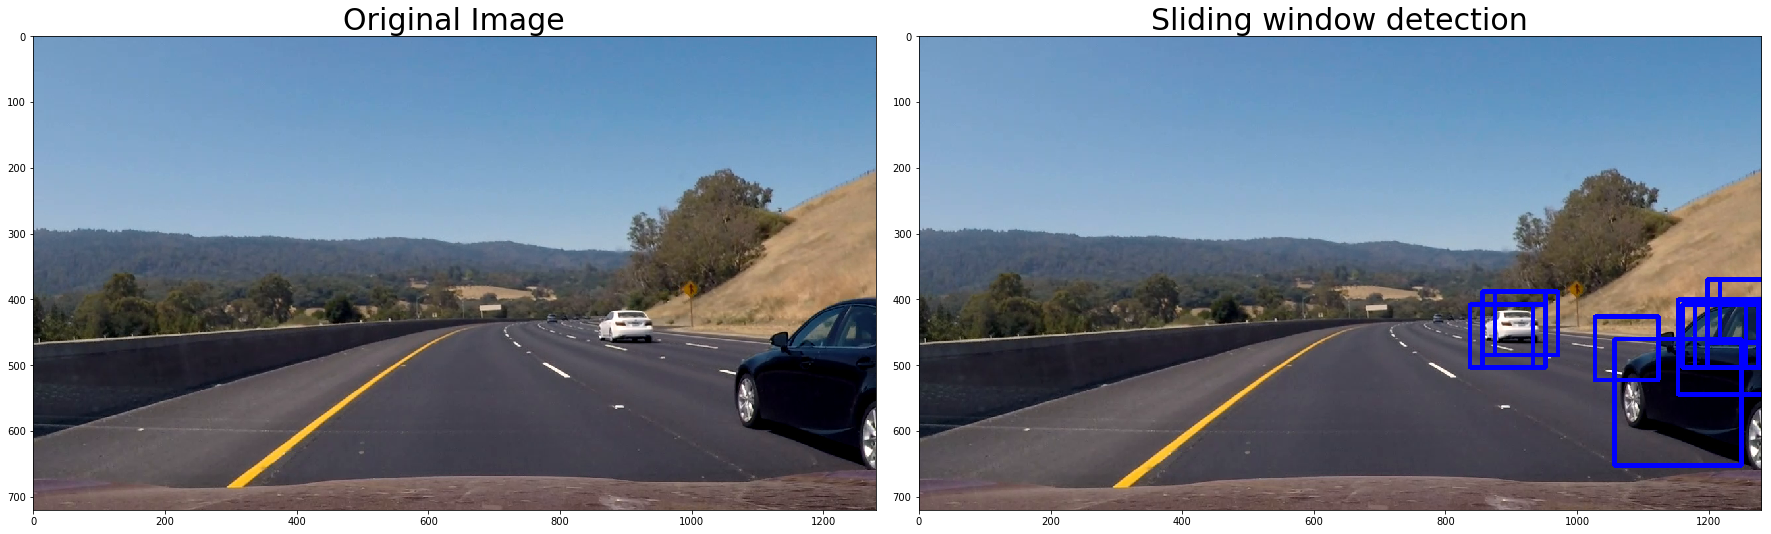

In [11]:
## Testing on a clip from video

clip  = VideoFileClip('project_video.mp4')
image = clip.get_frame(28.1)
# image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
svc1 = joblib.load('model_12_svc.pkl')

print('Finding window locations..')
print()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 500], 
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(144, 144), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[430, 550], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[460, 580], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    
print('Drawing windows on the image..')
print()
hot_windows = search_windows(image, windows, svc1, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)      

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(window_img, cmap='hot')
ax2.set_title('Sliding window detection', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

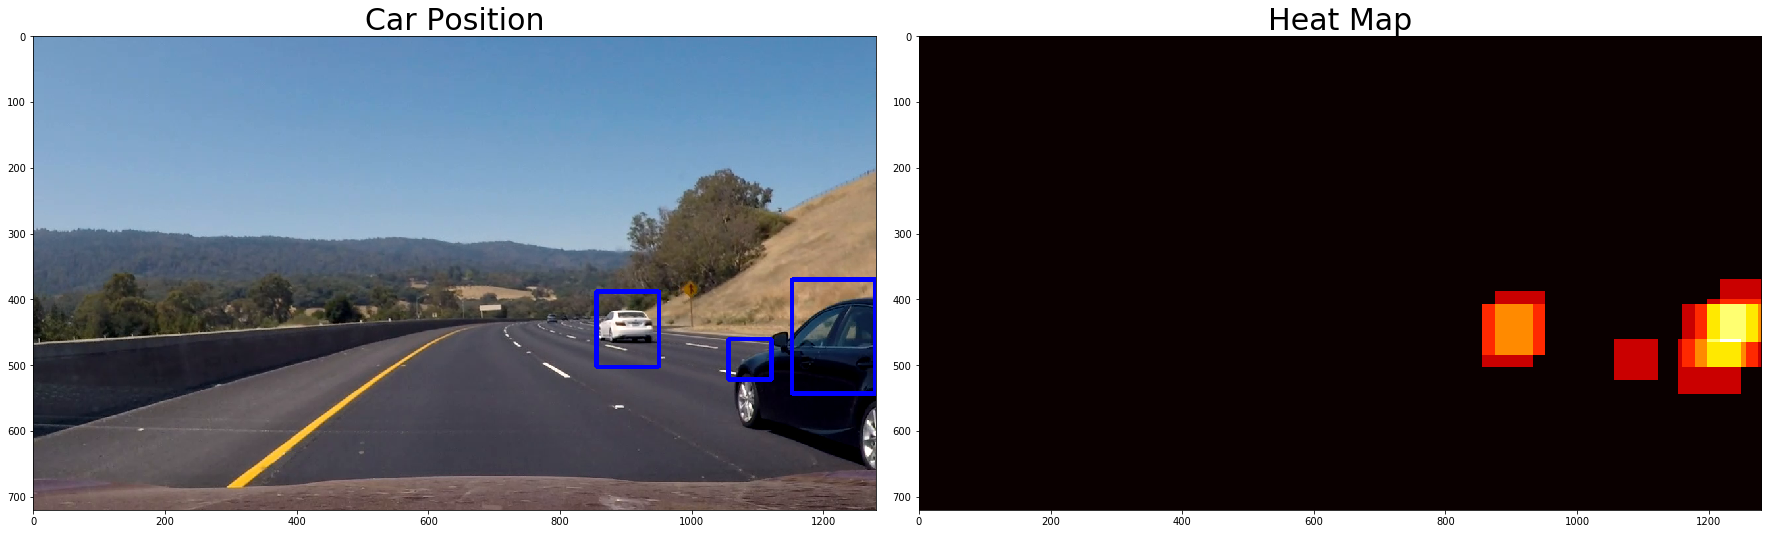

In [13]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
local_labels = label(heatmap)
box          = draw_labeled_bboxes(local_labels)
draw_img     = draw_boxes(np.copy(image), box)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Position', fontsize=30)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def process_image(image):
    
    draw_img = np.copy(image)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, 500], 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                        xy_window=(144, 144), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[430, 550], 
                        xy_window=(192, 192), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[460, 600], 
                        xy_window=(192, 192), xy_overlap=(0.75, 0.75))


    hot_windows = search_windows(image, windows, svc1, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)      

    previous.count += 1 
    
    if previous.count > 1 and len(previous.hot_windows) > 0:
        hot_wind = []
        for frame in previous.hot_windows:
            for wind in frame:
                hot_wind.append(wind)

        hot_wind = hot_wind + hot_windows

        heat         = np.zeros_like(image[:,:,0]).astype(np.float)
        heat         = add_heat(heat,hot_wind)    
        heat         = apply_threshold(heat,4)
        heatmap      = np.clip(heat, 0, 255)
        local_labels = label(heatmap)
        
        if local_labels[1]:
            bbox = draw_labeled_bboxes(local_labels)
            previous.hot_windows.append(bbox)
            previous.heat.append(heat)
        
        if len(previous.hot_windows)>5:
            del previous.hot_windows[0]
        
    else:
        heat         = np.zeros_like(image[:,:,0]).astype(np.float)
        heat         = add_heat(heat,hot_windows)    
        heat         = apply_threshold(heat,1)
        heatmap      = np.clip(heat, 0, 255)
        local_labels = label(heatmap)
        if local_labels[1]:
            bbox = draw_labeled_bboxes(local_labels)
            previous.hot_windows.append(bbox)
    
    if len(previous.heat) > 7:
        
        tmp = (previous.heat[0]>0).astype(np.int)
        for i in previous.heat[1:]:
            i   = (i>0).astype(np.int)
            tmp = np.bitwise_and(tmp, i)

        heat         = tmp*previous.heat[-1]
        heatmap      = np.clip(heat, 0, 255)
        local_labels = label(heatmap)
        if local_labels[1]:
            bbox = draw_labeled_bboxes(local_labels)
            draw_img = draw_boxes(draw_img, bbox, color=(0, 0, 255), thick=6)
            previous.hot_windows.append(bbox)
            del previous.hot_windows[0]
            del previous.heat[0]
            
        else:
            
            heatmap      = np.clip(previous.heat[-1], 0, 255)
            local_labels = label(heatmap)
            del previous.heat[-1]
                        
        
    return draw_img

# Video Processing

In [9]:
svc1 = joblib.load('model_12_svc.pkl')
train_file = 'train_12.p'
with open(train_file, mode='rb') as f:
    feat = pickle.load(f)
    
X_scaler = feat['scalar']
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

class prev():
    
    def __init__(self, hot_windows = [], heat = [], count = 0):
        
        self.hot_windows = hot_windows
        self.heat = heat
        self.count = count

previous = prev()


white_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [1:08:54<00:03,  3.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 1h 7min 17s, sys: 59.3 s, total: 1h 8min 17s
Wall time: 1h 8min 56s


# Output Video

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))